<a href="https://colab.research.google.com/github/zaimahfira/Project/blob/main/Prediksi_Suhu_kemayoran_LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

###Import Library

In [ ]:
import math
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

###Import Database

In [ ]:
#Koneksi ke Google Drive
#from google.colab import drive
#drive.mount('/content/drive')

In [ ]:
#Membaca dan menampilkan Dataset
df = pd.read_csv('/content/iklim_kemayoran_18_22.csv')
df.head()

,Tanggal,Tn,Tx,Tavg,RH_avg,RR,ff_avg
0,2018-01-01,25.0,33.2,28.6,78.0,46.4,1.0
1,2018-01-02,26.0,33.6,29.8,69.0,0.0,1.0
2,2018-01-03,27.0,31.2,28.4,77.0,0.0,1.0
3,2018-01-04,26.0,33.8,29.3,75.0,1.0,1.0
4,2018-01-05,27.0,30.8,28.9,68.0,0.5,3.0


###Eksplorasi Data

In [ ]:
#Mengecek nilai yang hilang
df.isnull().sum()/len(df)

Tanggal    0.000000
Tn         0.000000
Tx         0.000000
Tavg       0.000000
RH_avg     0.000000
RR         0.002206
ff_avg     0.057915
dtype: float64

In [ ]:
df=df.dropna(axis=0)

<Axes: >

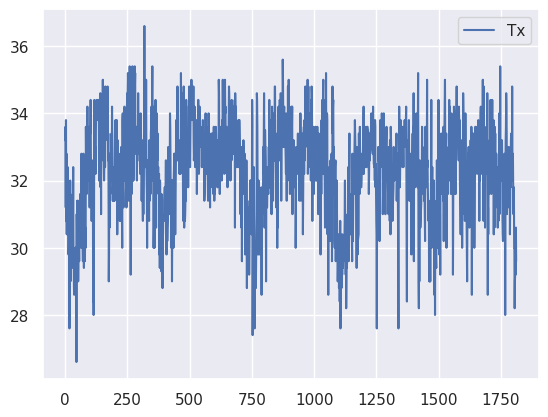

In [ ]:
#menampilkan suhu max
df[["Tx"]].plot()

In [ ]:
df = df.drop(['Tn','Tx','RH_avg','RR','ff_avg'],axis='columns')

In [ ]:
#Mempelajari dtypes kolom
print(df.dtypes)

Tanggal     object
Tavg       float64
dtype: object


In [ ]:
df

,Tanggal,Tavg
0,2018-01-01,28.6
1,2018-01-02,29.8
2,2018-01-03,28.4
3,2018-01-04,29.3
4,2018-01-05,28.9
...,...,...
1808,2022-12-27,26.3
1809,2022-12-28,25.9
1810,2022-12-29,26.2
1811,2022-12-30,26.3


In [ ]:
#Mengubah tanggal menjadi index
con = df['Tanggal']
df['Tanggal']=pd.to_datetime(df['Tanggal'])
df.set_index('Tanggal',inplace=True)

#Cek tipe data index
df.index

DatetimeIndex(['2018-01-01', '2018-01-02', '2018-01-03', '2018-01-04',
               '2018-01-05', '2018-01-06', '2018-01-07', '2018-01-08',
               '2018-01-09', '2018-01-10',
               ...
               '2022-12-22', '2022-12-23', '2022-12-24', '2022-12-25',
               '2022-12-26', '2022-12-27', '2022-12-28', '2022-12-29',
               '2022-12-30', '2022-12-31'],
              dtype='datetime64[ns]', name='Tanggal', length=1708, freq=None)

In [ ]:
#Menginisialkan variabel Tavg sebagai data time series
ts = df['Tavg']
ts.head(10)

Tanggal
2018-01-01    28.6
2018-01-02    29.8
2018-01-03    28.4
2018-01-04    29.3
2018-01-05    28.9
2018-01-06    28.9
2018-01-07    28.8
2018-01-08    28.6
2018-01-09    28.4
2018-01-10    28.3
Name: Tavg, dtype: float64

###Visualisasi Rata-Rata Suhu

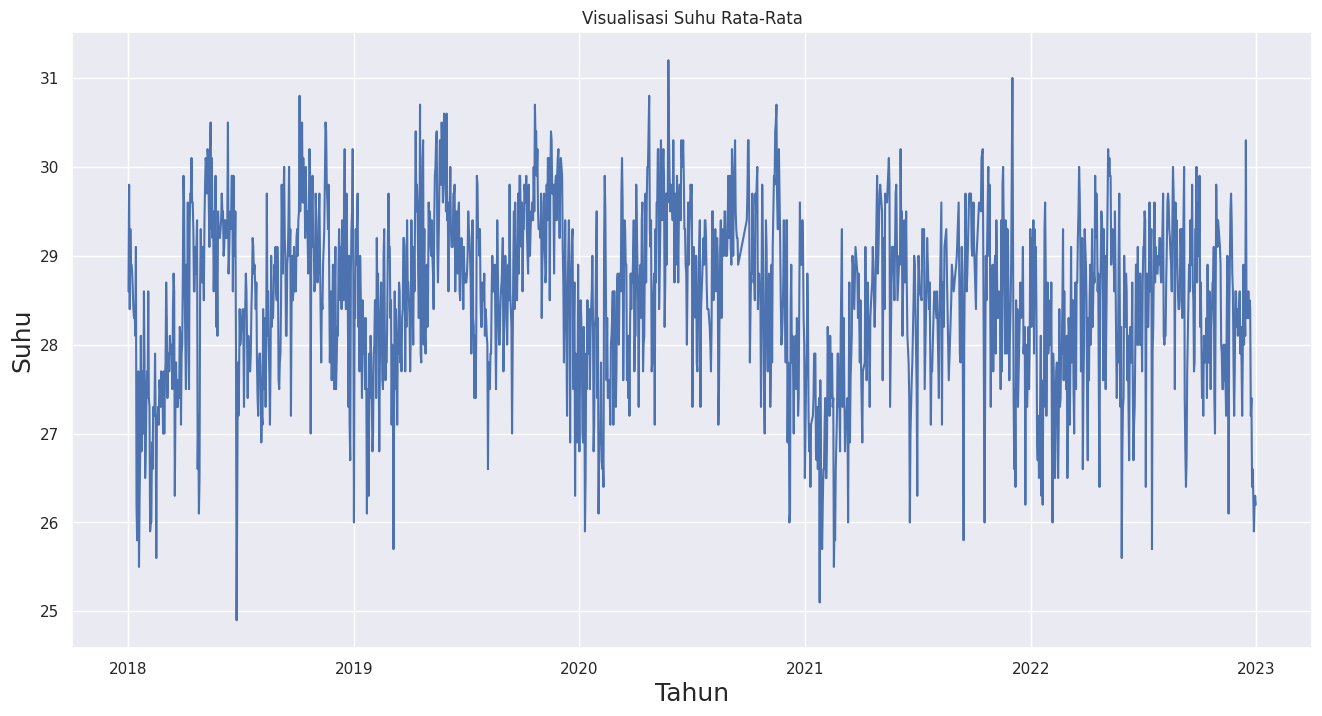

In [ ]:
plt.figure(figsize=(16,8))
plt.title('Visualisasi Suhu Rata-Rata')
plt.plot(df['Tavg'])
plt.xlabel('Tahun', fontsize=18)
plt.ylabel('Suhu', fontsize=18)
plt.show()

In [ ]:
#data = pd.DataFrame(list(df['Tavg']), index=df['Tanggal'], columns=['temp'])

###Uji Stasioneritas Data
####membuat data frame baru dengan variabel high dan diubah dalam bentuk array. Kemudian variabel digunakan untuk menyimpan dataset dengan data training 80%

In [ ]:
#Membuat dataframe baru dari kolom Tavg untuk di training
data = df.filter(['Tavg'])
dataset = data.values
len(dataset)

1708

In [ ]:
#Menghitung jumlah baris pada model untuk di training
training_data_size=math.ceil(len(dataset)*.8)

In [ ]:
#Normalisasi nilai high menjadi antara 0 dan 1
scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(dataset)
scaled_data

array([[0.58730159],
       [0.77777778],
       [0.55555556],
       ...,
       [0.20634921],
       [0.22222222],
       [0.20634921]])

In [ ]:
#Membuat scaled training dataset
train_data = scaled_data[0:training_data_size,:]
#Memisahkan data x_train dan y_train pada dataset
x_train = []
y_train = []
for i in range(50, len(train_data)):
    x_train.append(train_data[i-50:i,0])
    y_train.append(train_data[i,0])
    if i<=51:
        print(x_train)
        print(y_train)

[array([0.58730159, 0.77777778, 0.55555556, 0.6984127 , 0.63492063,
       0.63492063, 0.61904762, 0.58730159, 0.55555556, 0.53968254,
       0.55555556, 0.50793651, 0.66666667, 0.20634921, 0.14285714,
       0.3968254 , 0.44444444, 0.0952381 , 0.22222222, 0.3015873 ,
       0.50793651, 0.3015873 , 0.44444444, 0.38095238, 0.33333333,
       0.58730159, 0.46031746, 0.25396825, 0.3015873 , 0.3968254 ,
       0.44444444, 0.3968254 , 0.58730159, 0.3968254 , 0.38095238,
       0.15873016, 0.17460317, 0.17460317, 0.31746032, 0.26984127,
       0.38095238, 0.36507937, 0.36507937, 0.47619048, 0.36507937,
       0.11111111, 0.36507937, 0.34920635, 0.38095238, 0.34920635])]
[0.42857142857142927]
[array([0.58730159, 0.77777778, 0.55555556, 0.6984127 , 0.63492063,
       0.63492063, 0.61904762, 0.58730159, 0.55555556, 0.53968254,
       0.55555556, 0.50793651, 0.66666667, 0.20634921, 0.14285714,
       0.3968254 , 0.44444444, 0.0952381 , 0.22222222, 0.3015873 ,
       0.50793651, 0.3015873 , 0.444

In [ ]:
#Konversi x_train dan y_train menjadi numpy array
x_train, y_train = np.array(x_train), np.array(y_train)

In [ ]:
#Mengubah bentuk data
x_train = np.reshape(x_train, (x_train.shape[0],x_train.shape[1],1))
x_train.shape

(1317, 50, 1)

####Model LSTM

In [ ]:
#Membangun model LSTM dengan 50 neuron dan 2 lapisan Dense, satu dengan 25 neuron  dan lainnya dengan 1 neuron
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape = (x_train.shape[1],1)))
model.add(LSTM(50, return_sequences=False))
model.add(Dense(25))
model.add(Dense(10))
model.add(Dense(1))

####Kompilasi model menggunakan fungsi Mean Squared Error (MSE)

In [ ]:
#Compile model
model.compile(optimizer='adam', loss='mean_squared_error')
print(model.summary())

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_10 (LSTM)              (None, 50, 50)            10400     
                                                                 
 lstm_11 (LSTM)              (None, 50)                20200     
                                                                 
 dense_15 (Dense)            (None, 25)                1275      
                                                                 
 dense_16 (Dense)            (None, 10)                260       
                                                                 
 dense_17 (Dense)            (None, 1)                 11        
                                                                 
Total params: 32,146
Trainable params: 32,146
Non-trainable params: 0
_________________________________________________________________
None


In [ ]:
#Train model
model.fit(x_train, y_train, batch_size=32, epochs=100)

Epoch 1/100
42/42 [==============================] - 6s 53ms/step - loss: 0.0133
Epoch 2/100
42/42 [==============================] - 2s 55ms/step - loss: 0.0132
Epoch 3/100
42/42 [==============================] - 2s 51ms/step - loss: 0.0132
Epoch 4/100
42/42 [==============================] - 3s 61ms/step - loss: 0.0132
Epoch 5/100
42/42 [==============================] - 3s 67ms/step - loss: 0.0132
Epoch 6/100
42/42 [==============================] - 2s 54ms/step - loss: 0.0132
Epoch 7/100
42/42 [==============================] - 2s 50ms/step - loss: 0.0132
Epoch 8/100
42/42 [==============================] - 2s 53ms/step - loss: 0.0132
Epoch 9/100
42/42 [==============================] - 2s 48ms/step - loss: 0.0132
Epoch 10/100
42/42 [==============================] - 3s 77ms/step - loss: 0.0133
Epoch 11/100
42/42 [==============================] - 2s 55ms/step - loss: 0.0132
Epoch 12/100
42/42 [==============================] - 2s 56ms/step - loss: 0.0132
Epoch 13/100
42/42 [=====

####Membuat test Dataset

In [ ]:
#Test Dataset
test_data = scaled_data[training_data_size-50:, :]
#Membuat x_test dan y_test dataset
x_test = []
y_test = dataset[training_data_size:, :]
for i in range(50, len(test_data)):
    x_test.append(test_data[i-50:i, 0])

In [ ]:
#konversi x_test ke numpy array
x_test = np.array(x_test)

In [ ]:
#Membentuk data yang diterima oleh LSTM
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1],1))

####Prediksi Data

In [ ]:
#Mendapatkan nilai harga prediksi model
predictions = model.predict(x_test)
predictions = scaler.inverse_transform(predictions)

11/11 [==============================] - 1s 18ms/step


In [ ]:
predictions

array([[28.60809 ],
       [28.41909 ],
       [27.77955 ],
       [28.100721],
       [28.379984],
       [28.070805],
       [28.092115],
       [28.081438],
       [28.326633],
       [28.11187 ],
       [28.448023],
       [27.682716],
       [27.095364],
       [28.018267],
       [27.814457],
       [27.327316],
       [27.191835],
       [27.61485 ],
       [27.772243],
       [27.827835],
       [27.56051 ],
       [27.201252],
       [27.42656 ],
       [28.077549],
       [27.638214],
       [27.606735],
       [27.877903],
       [27.871977],
       [28.16963 ],
       [28.557913],
       [27.926792],
       [28.320623],
       [27.933596],
       [28.008118],
       [27.816206],
       [28.092833],
       [27.396791],
       [27.484598],
       [28.114403],
       [28.038668],
       [27.610455],
       [27.922836],
       [28.498068],
       [27.994518],
       [28.092539],
       [28.281128],
       [27.873446],
       [27.584595],
       [28.037153],
       [28.356531],


In [ ]:
#Menghitung nilai RMSE
rmse = np.sqrt(np.mean(predictions - y_test)**2)
rmse

0.04930553715949188

<ipython-input-186-a6e804944507>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['predictions'] = predictions


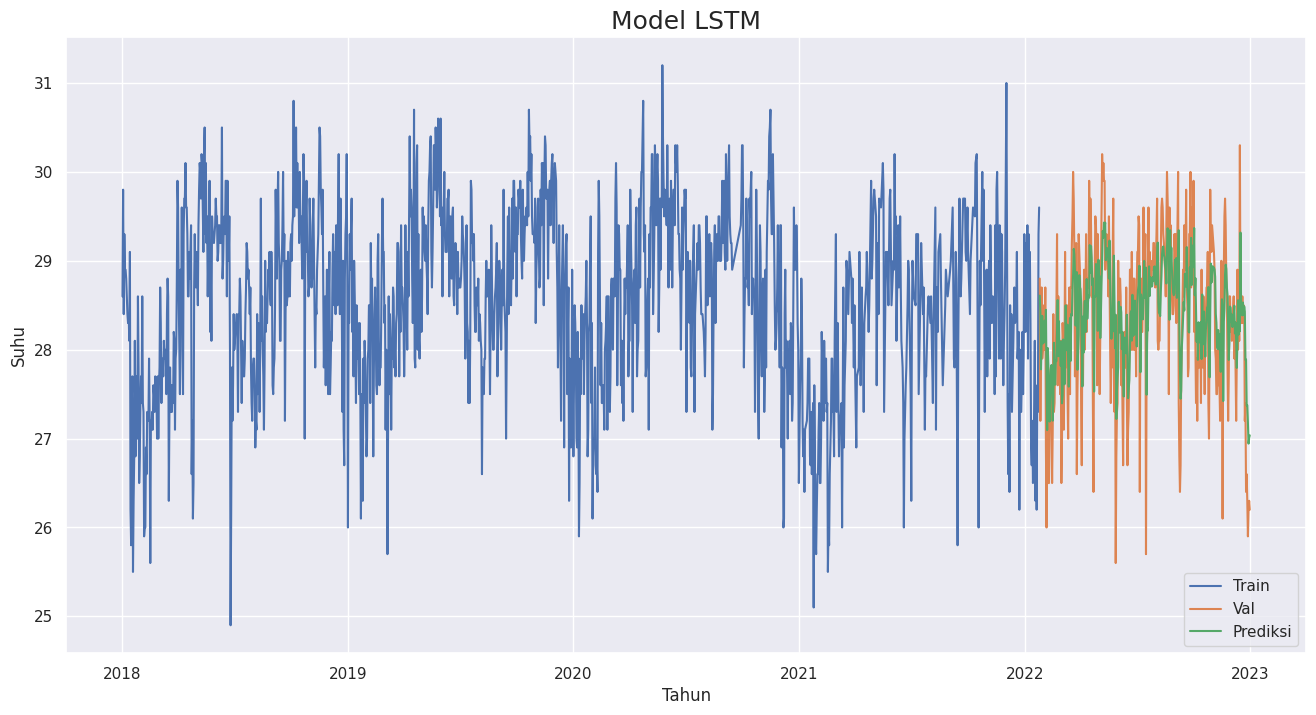

In [ ]:
#Membuat data untuk grafik
train = data[:training_data_size]
valid = data[training_data_size:]
valid['predictions'] = predictions

#Visualisasi data
plt.figure(figsize=(16,8))
plt.title('Model LSTM', fontsize=18)
plt.xlabel('Tahun', fontsize=12)
plt.ylabel('Suhu', fontsize=12)
plt.plot(train['Tavg'])
plt.plot(valid[['Tavg', 'predictions']])
plt.legend(['Train', 'Val', 'Prediksi'], loc='lower right')
plt.show()

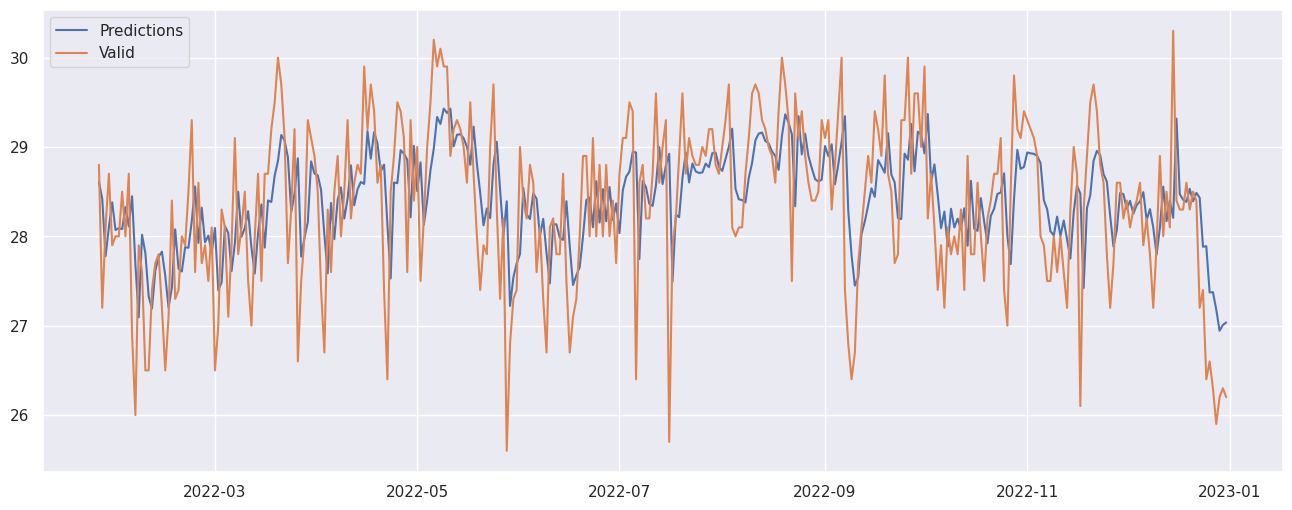

In [ ]:
plt.figure(figsize = (16, 6))
plt.plot(valid['predictions'])
plt.plot(valid['Tavg'])
plt.legend(['Predictions', 'Valid'])
plt.show()

In [ ]:
#Menampilkan data harga yang valid dan prediksinya
valid

,Tavg,predictions
Tanggal,,
2022-01-25,28.8,28.608089
2022-01-26,27.2,28.419090
2022-01-27,28.1,27.779551
2022-01-28,28.7,28.100721
2022-01-29,27.9,28.379984
...,...,...
2022-12-27,26.3,27.375381
2022-12-28,25.9,27.180031
2022-12-29,26.2,26.943367
